# Posterior re-weighting for GW tidal cosmology

Using lambda-0 lambda-k relations. Uniform prior on lambda-0 between 0 and 1000

In [1]:
import json
import pickle

import numpy as np
import scipy as sp

import bilby
import matplotlib.pyplot as plt
import pandas as pd

import corner

In [2]:
filename = \
    '/home/deep/work/campus-cluster-runs/gw-tidal-cosmology/lambda-k-relations-gw170817-uniform-prior/lambda-k-relations-gw170817_result.json'
result = bilby.result.read_in_result(filename=filename)

In [3]:
result.posterior.head()

,mass_ratio,chirp_mass,luminosity_distance,dec,ra,theta_jn,psi,a_1,a_2,tilt_1,tilt_2,phi_12,phi_jl,lambda_0_0,geocent_time,phase,log_likelihood,log_prior
0,0.861873,1.197600,44.136973,-0.219365,3.298510,2.773023,2.702302,0.016595,0.003461,1.318539,0.776614,5.357300,0.589836,191.363667,1.187009e+09,0.0,465.011129,-6.807020
1,0.880972,1.197765,38.160777,-0.280139,3.367138,2.666372,1.901688,0.038267,0.002087,1.138373,0.358173,2.114706,5.175340,223.483466,1.187009e+09,0.0,466.517837,-7.626462
2,0.832970,1.197477,40.875761,-0.266040,3.355750,2.443173,2.338884,0.041961,0.033608,1.425475,1.714382,5.795830,0.041949,125.201099,1.187009e+09,0.0,467.206805,-6.023305
3,0.993098,1.197802,43.319057,-0.225906,3.289043,2.820430,3.133351,0.026296,0.009949,0.857348,0.253062,5.623906,5.385123,351.667467,1.187009e+09,0.0,467.613889,-8.254170
4,0.923241,1.197792,29.676681,-0.371371,3.364187,2.163608,2.290218,0.033623,0.011420,0.638939,1.665986,4.568181,3.985603,96.435132,1.187009e+09,0.0,467.968817,-6.934575


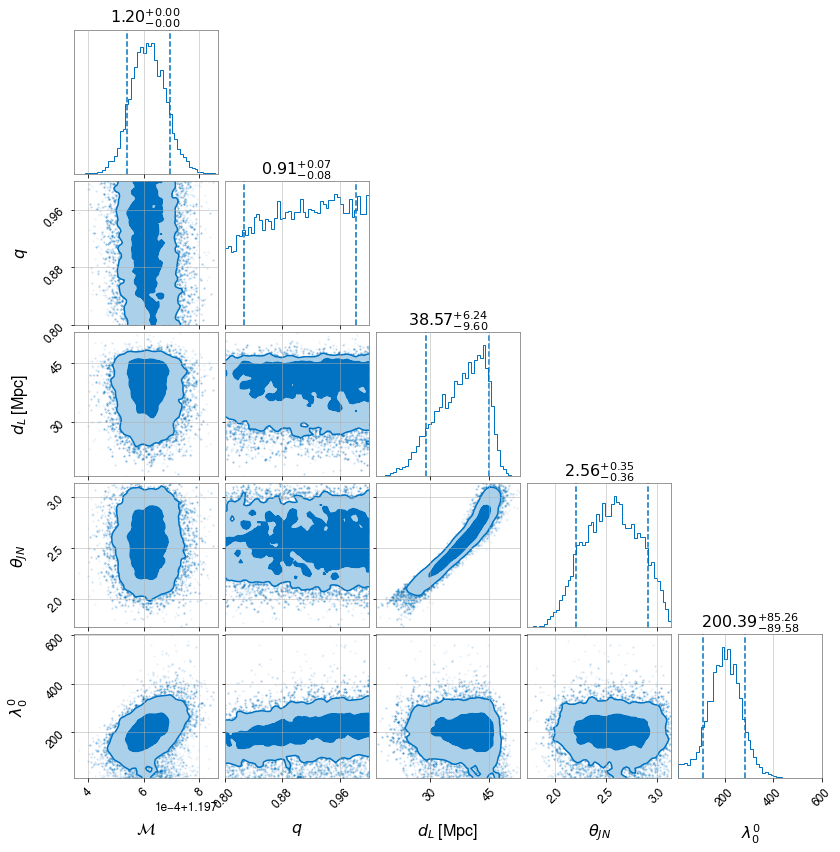

In [4]:
params = ['chirp_mass', 'mass_ratio', 'luminosity_distance', 'theta_jn', 'lambda_0_0']
result.plot_corner(params, quantiles=(0.1, 0.9), levels=(0.5, 0.9))

In [5]:
# sample priors
r = result.priors.sample(10000)

mc_prior = r['chirp_mass']
q_prior = r['mass_ratio']

tot_mass_prior = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_total_mass(mc_prior, q_prior)
mass1_prior = tot_mass_prior/(1 + q_prior)
mass2_prior = tot_mass_prior - mass1_prior

mass1_prior_source = mass1_prior/(1.0099)
mass2_prior_source = mass2_prior/(1.0099)

lambda_0_0_prior = r['lambda_0_0']

## Map the prior on lambda_0_0 to lambda-tilde

In [6]:
from t_cosmo import lambda_k_relations

In [7]:
lambda1_prior = lambda_k_relations.get_lambda_from_mass(mass1_prior_source, lambda_0_0_prior, M0=1.4)
lambda2_prior = lambda_k_relations.get_lambda_from_mass(mass2_prior_source, lambda_0_0_prior, M0=1.4)

In [8]:
mask = ~(np.isnan(lambda1_prior) + np.isnan(lambda2_prior))
lambda1_prior = lambda1_prior[mask]
lambda2_prior = lambda2_prior[mask]

In [9]:
lambda_tilde_prior = bilby.gw.conversion.lambda_1_lambda_2_to_lambda_tilde(
    lambda1_prior, lambda2_prior,
    mass1_prior_source[mask], mass2_prior_source[mask]
)

Text(0.5, 0, '$\\tilde{\\Lambda}$ Prior')

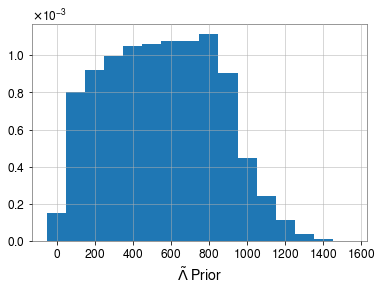

In [10]:
# choice of bins. Ensure zero is a bin center
bins = [-50 + 100*n for n in range(17)]

mm, bb, pp = plt.hist(lambda_tilde_prior, bins=bins, density=True)
plt.xlabel("$\\tilde{\Lambda}$ Prior")

In [11]:
norm_freq_lambda_tilde = mm
bin_centers = 0.5*(bb[1:] + bb[:-1])

lambda_tilde_freq_interpolant  = sp.interpolate.interp1d(
    bin_centers, norm_freq_lambda_tilde, kind='cubic',
    fill_value=(0.,  0.), bounds_error=False
)

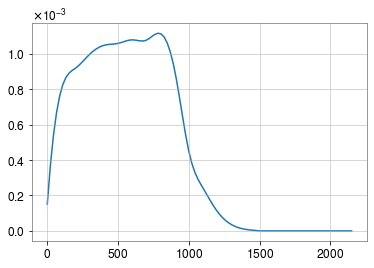

In [12]:
# plot the interpolant
fiducial_lambda_tilde = np.linspace(0, 2150, 100)
fiducial_wts = lambda_tilde_freq_interpolant(fiducial_lambda_tilde)

plt.plot(fiducial_lambda_tilde, fiducial_wts)

# Re-weight using inverse of the count above

In [13]:
# diagnostic plot of lambda tilde with the inverse weighting of itself: should be flat
wts = 1./lambda_tilde_freq_interpolant(lambda_tilde_prior)
wts /= np.sum(wts)

# verify all weights are finite
print(np.where(np.isnan(wts)))
print(np.where(np.isinf(wts)))

(array([], dtype=int64),)
(array([], dtype=int64),)


Text(0.5, 0, 'Reweighted lambda-tilde prior')

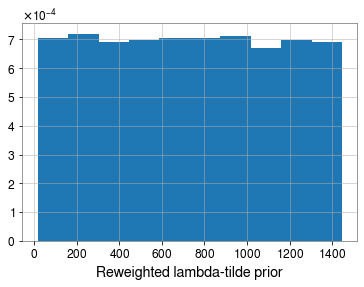

In [14]:
_, *p = plt.hist(lambda_tilde_prior, weights=wts, density=True)
plt.xlabel('Reweighted lambda-tilde prior')

In [15]:
# Compute the weight of every lambda-tilde posterior sample

chirp_mass_posterior = result.posterior.chirp_mass
mass_ratio_posterior = result.posterior.mass_ratio

total_mass_posterior = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_total_mass(
    chirp_mass_posterior, mass_ratio_posterior
)

mass1_posterior = total_mass_posterior/(1 + mass_ratio_posterior)
mass2_posterior = total_mass_posterior/(1 + mass_ratio_posterior)

# redshift = 0.0099
mass1_source_posterior = mass1_posterior/1.0099
mass2_source_posterior = mass2_posterior/1.0099

lambda1_posterior = lambda_k_relations.get_lambda_from_mass(mass1_source_posterior,
                                                             result.posterior.lambda_0_0, M0=1.4)
lambda2_posterior = lambda_k_relations.get_lambda_from_mass(mass2_source_posterior,
                                                             result.posterior.lambda_0_0, M0=1.4)

In [16]:
# remove posterior samples that give negative lambda
keep = lambda1_posterior < 0
keep |= lambda2_posterior < 0
keep = ~keep

lambda_tilde_posterior = bilby.gw.conversion.lambda_1_lambda_2_to_lambda_tilde(
    lambda1_posterior, lambda2_posterior,
    mass1_posterior, mass2_posterior
)

# filter out further nans in the lambda_tilde posterior
keep &= ~np.isnan(lambda_tilde_posterior)
keep &= ~np.isinf(lambda_tilde_posterior)

lambda1_posterior = lambda1_posterior[keep]
lambda2_posterior = lambda2_posterior[keep]
mass1_posterior = mass1_posterior[keep]
mass2_posterior = mass2_posterior[keep]
lambda_tilde_posterior = lambda_tilde_posterior[keep]

In [17]:
posterior_wts = 1./lambda_tilde_freq_interpolant(lambda_tilde_posterior)
posterior_wts /= np.sum(posterior_wts)

# verify all posterior weights are finite
print(np.where(np.isnan(posterior_wts)))
print(np.sum(posterior_wts))

(array([], dtype=int64),)
1.0


### Reweight all posterior samples

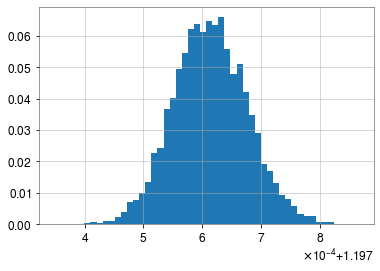

In [18]:
# verify chirp mass
chirp_mass_posterior = result.posterior.chirp_mass[keep]
_, *p = plt.hist(chirp_mass_posterior, weights=posterior_wts, bins=50)

Text(0.5, 0, '$\\Lambda_0^0$')

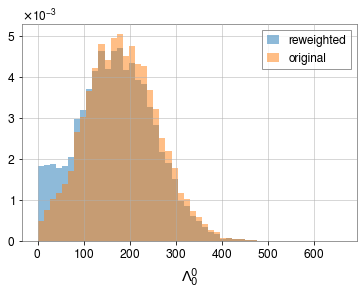

In [19]:
# reweight lambda_0_0

lambda_0_0_posterior =  result.posterior.lambda_0_0[keep]
_, _b, _p = plt.hist(lambda_0_0_posterior, weights=posterior_wts,
                     bins=50, density=True, alpha=0.5, label='reweighted')
_, _b, _p = plt.hist(lambda_0_0_posterior,
                     bins=_b, density=True, alpha=0.5, label='original')
plt.legend()
plt.xlabel("$\Lambda_0^0$")

# LIGO Virgo results

Using samples from the LIGO/Virgo neutron star radius measurement paper. This work used universal relations

```bash
! wget https://dcc.ligo.org/public/0152/P1800115/005/EoS-insensitive_posterior_samples.dat
```

In [20]:
df_ligo_results = pd.read_table('EoS-insensitive_posterior_samples.dat', skiprows=1, sep=' ',
                                skipinitialspace=True, names=('m1_source_frame_Msun',
                                                              'm2_source_frame_Msun',
                                                              'Lambda1', 'Lambda2',
                                                              'Radius1_km', 'Radius2_km'))

In [21]:
df_ligo_results.head()

,m1_source_frame_Msun,m2_source_frame_Msun,Lambda1,Lambda2,Radius1_km,Radius2_km
0,1.543236,1.205749,97.068200,248.541197,10.730811,9.358211
1,1.482590,1.253115,19.677667,280.480973,8.186003,9.833989
2,1.541613,1.206940,31.524739,235.511540,9.149591,9.373914
3,1.562878,1.191476,49.572338,409.681755,9.951128,10.102846
4,1.656298,1.128266,27.441288,246.930128,9.602853,9.395534


In [22]:
df_ligo_results['lambda_tilde'] = bilby.gw.conversion.lambda_1_lambda_2_to_lambda_tilde(
    df_ligo_results.Lambda1, df_ligo_results.Lambda2,
    df_ligo_results.m1_source_frame_Msun, df_ligo_results.m2_source_frame_Msun
)

Text(0.5, 0, '$\\tilde{\\Lambda}$')

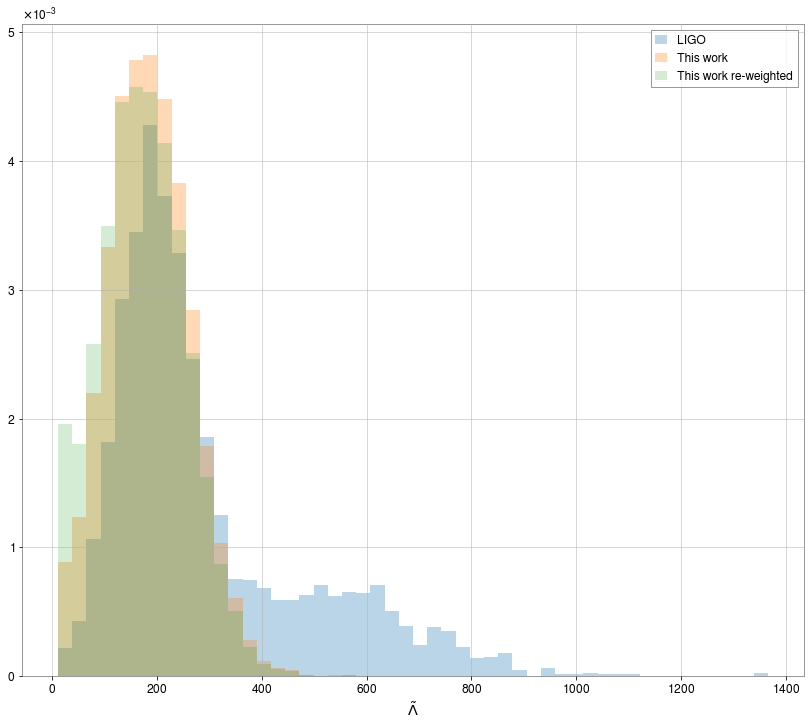

In [23]:
plt.figure(figsize=(14, 12))

mm, bb, pp = plt.hist(df_ligo_results.lambda_tilde, bins=50, alpha=0.3,
                      label='LIGO', density=True)
plt.hist(lambda_tilde_posterior, alpha=0.3, bins=bb, density=True, label='This work')
plt.hist(lambda_tilde_posterior, alpha=0.2, bins=bb, weights=posterior_wts,
         density=True, label='This work re-weighted')
plt.legend()
plt.xlabel('$\\tilde{\Lambda}$')